In [1]:
import pandas as pd
import seaborn as sn
import numpy as np
import math
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from joblib import dump
from fextractor import FeatureExtractor

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
np.random.seed(1)

### Датасет

In [4]:
extractor = FeatureExtractor("../data/train_features.csv", "../data/test_features.csv")
extractor.remove_little_sd()
extractor.split_for_clf()
extractor.fill_with_medians()
extractor.split_for_anomaly()
extractor.drop_columns()
selected_columns = extractor.select_best_features()

x_train, x_test, y_train, y_test, X_test, Y_test = extractor.get_data()
x_train_anomaly, x_test_anomaly, y_train_anomaly, y_test_anomaly = extractor.get_data(clf=False)

In [5]:
# medians_insider = []
# medians_non_insider = []
# cols = []
# special_keys = [
#     "Key.esc",
#     "Key.tab",
#     "Key.caps_lock",
#     "Key.shift",
#     "Key.ctrl",
#     "Key.alt",
#     "Key.cmd",
#     "Key.space",
#     "Key.enter",
#     "Key.backspace",
# ]
# for col in x_train.columns:
#     # не считаем медианы для таргета и частотных признаков
#     if col != 'is_insider' and col not in special_keys:
#         cols.append(col)
#         medians_insider.append(x_train[x_train['is_insider'] == 1][col].median())
#         medians_non_insider.append(x_train[x_train['is_insider'] == 0][col].median())   

In [6]:
# rels = {
#     "dwell": [0,0], # длительность нажатия первой буквы
#     "interval": [0,0], # промежуток между отпусканием первой и нажатием второй буквы
#     "flight": [0,0], # промежуток между нажатием первой и нажатием второй буквы
#     "up_to_up": [0,0], # промежуток между отпусканием первой и отпусканием второй
#     "dwell_first": [0,0], # длительность нажатия первой буквы
#     "dwell_second": [0,0], # длительность нажатия второй буквы
#     "dwell_third": [0,0], # длительность нажатия третьей буквы
#     "interval_first": [0,0], # промежуток между отпусканием первой и нажатием второй буквы
#     "interval_second": [0,0], # промежуток между отпусканием второй и нажатием третьей буквы
#     "flight_first": [0,0], # промежуток между нажатием первой и нажатием второй буквы
#     "flight_second": [0,0], # промежуток между нажатием второй и нажатием третьей буквы    
#     "up_to_up_first": [0,0], # промежуток между отпусканием первой и отпусканием второй
#     "up_to_up_second": [0,0], # промежуток между отпусканием второй и отпусканием третьей
#     "latency": [0,0], # промежуток между нажатием первой и отпусканием третьей
# }
# for i in range(len(medians_insider)):
#     for k,v in rels.items():
#         if k in cols[i]:
#             if medians_insider[i] < medians_non_insider[i]:
#                 v[0] += 1
#             v[1] += 1

# for k,v in rels.items():
#     print(k,v[0],v[1],(v[1] - v[0]) / v[1] * 100 if v[1]-v[0] != 0 else 0)

### Графики

In [7]:
# def plot_medians(name, medians_insider, medians_non_insider, labels):
#     plt.figure(figsize=(30,20))
#     plt.plot(medians_insider, '--rx', label = 'anomalous behaviour')
#     plt.plot(medians_non_insider, '--bo', label = 'normal behaviour')
#     plt.legend()
#     plt.xticks(np.arange(len(labels)), labels=labels, rotation=90)
#     plt.ylabel('Duration, ms')
#     plt.xlabel('Features')
#     plt.savefig(name, bbox_inches='tight')
#     plt.show()

In [8]:
def plot3d_samples(train, test, cols):
    x_train_insider = train[train['is_insider'] == 1][cols[0]].values
    y_train_insider = train[train['is_insider'] == 1][cols[1]].values
    z_train_insider = train[train['is_insider'] == 1][cols[2]].values
    
    x_train_non_insider = train[train['is_insider'] == 0][cols[0]].values
    y_train_non_insider = train[train['is_insider'] == 0][cols[1]].values
    z_train_non_insider = train[train['is_insider'] == 0][cols[2]].values
    
    x_test_insider = test[test['is_insider'] == 1][cols[0]].values
    y_test_insider = test[test['is_insider'] == 1][cols[1]].values
    z_test_insider = test[test['is_insider'] == 1][cols[2]].values
    
    x_test_non_insider = test[test['is_insider'] == 0][cols[0]].values
    y_test_non_insider = test[test['is_insider'] == 0][cols[1]].values
    z_test_non_insider = test[test['is_insider'] == 0][cols[2]].values
    
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ti = ax.scatter(x_train_insider, y_train_insider, z_train_insider, c='r', marker='o', label="Аномальное поведение в обучаемой выборке")
    tni = ax.scatter(x_train_non_insider, y_train_non_insider, z_train_non_insider, c='g', marker='o', label="Нормальное поведение в обучаемой выборке")
    Ti = ax.scatter(x_test_insider, y_test_insider, z_test_insider, c='r', marker='^', label="Аномальное поведение в тестовой выборке")
    Tni = ax.scatter(x_test_non_insider, y_test_non_insider, z_test_non_insider, c='g', marker='^', label="Нормальное поведение в тестовой выборке")

    ax.set_xlabel(cols[0])
    ax.set_ylabel(cols[1])
    ax.set_zlabel(cols[2])
#     ax.legend()
    
#     plt.title("Распределение примеров")
    
    plt.show()

In [9]:
def plot3d(name, features, truth, preds, cols, anomaly=True):
    x = features[cols[0]]
    y = features[cols[1]]
    z = features[cols[2]]
    
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    
    
    if anomaly:
        is_insider = -1
        non_insider = 1
    else:
        is_insider = 1
        non_insider = 0
    
    # calculate cases
    tn = np.logical_and(preds==is_insider, truth==is_insider)
    tp = np.logical_and(preds==non_insider, truth==non_insider)
    fn = np.logical_and(preds==is_insider, truth==non_insider)
    fp = np.logical_and(preds==non_insider, truth==is_insider)
    
    ax.scatter(x[tp], y[tp], z[tp],
               marker="o", edgecolors="lime", c="blue", lw=3, s=80, label="ИП")
    ax.scatter(x[tn], y[tn], z[tn],
               marker="o", edgecolors="red", c="peru", lw=3, s=80, label="ИО",)
    ax.scatter(x[fn], y[fn], z[fn],
               marker="o", edgecolors="red", c="blue", lw=3, s=80, label="ЛО")
    ax.scatter(x[fp], y[fp], z[fp],
               marker="o", edgecolors="lime", c="peru", lw=3, s=80, label="ЛП")
    
    ax.set_xlabel(cols[0])
    ax.set_ylabel(cols[1])
    ax.set_zlabel(cols[2])
#     ax.legend()
    
    plt.title(name)
    plt.show()

### Выделение признаков

In [10]:
# # график изначального относительного распределения 
# # медиан признаков нарушителя и не нарушителя

# # первая половина признаков
# plot_medians(
#     "features_1.png",
#     medians_insider[:len(medians_insider) // 2], 
#     medians_non_insider[:len(medians_non_insider) // 2],
#     cols[:len(cols) // 2]
# )
# # вторая половина признаков
# plot_medians(
#     "features_2.png",
#     medians_insider[len(medians_insider) // 2:], 
#     medians_non_insider[len(medians_non_insider) // 2:],
#     cols[len(cols) // 2:]
# )

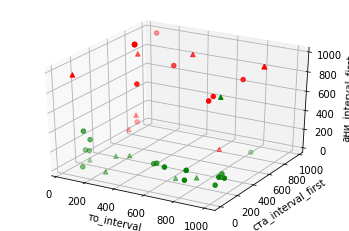

In [11]:
plot3d_samples(pd.concat([pd.concat([x_train, x_test]), pd.concat([y_train, y_test])], axis=1), 
       pd.concat([X_test, Y_test], axis=1), selected_columns)

### Метрики 

In [12]:
def report(clf, x_train, y_train, x_test, y_test, X_test, Y_test):
    y_pred = clf.fit(x_train, y_train).predict(x_test)
    y_pred_train = clf.predict(x_train)
    Y_pred = clf.predict(X_test)
    # plot the train and validation
    plot3d(k + " | Обучающая выборка", 
        pd.concat([x_train, x_test]), 
        pd.concat([y_train, y_test]).values, 
        np.concatenate([y_pred_train, y_pred]), 
        selected_columns, anomaly=False)
    # plot test
    plot3d(k + " | Тестовая выборка", X_test, Y_test.values, Y_pred, selected_columns, anomaly=False)
    print("accuracy train:", clf.score(x_train,y_train), "accuracy validation", accuracy_score(y_test, y_pred), "accuracy_test", accuracy_score(Y_test, Y_pred))
    print(classification_report(y_train, clf.predict(x_train)))    
    print(classification_report(y_test, y_pred))
    print(classification_report(Y_test, Y_pred))

### Модели c учителем

Logistic Regression


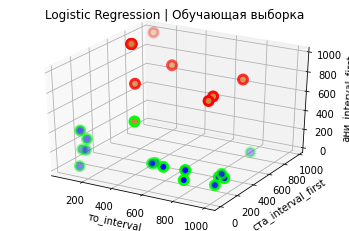

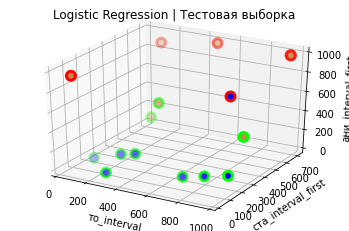

accuracy train: 1.0 accuracy validation 0.9 accuracy_test 0.75
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        11
           1       1.00      1.00      1.00        11

    accuracy                           1.00        22
   macro avg       1.00      1.00      1.00        22
weighted avg       1.00      1.00      1.00        22

              precision    recall  f1-score   support

           0       0.83      1.00      0.91         5
           1       1.00      0.80      0.89         5

    accuracy                           0.90        10
   macro avg       0.92      0.90      0.90        10
weighted avg       0.92      0.90      0.90        10

              precision    recall  f1-score   support

           0       0.70      0.88      0.78         8
           1       0.83      0.62      0.71         8

    accuracy                           0.75        16
   macro avg       0.77      0.75      0.75        16
weighted av

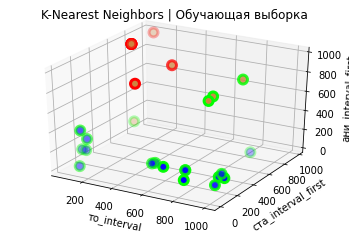

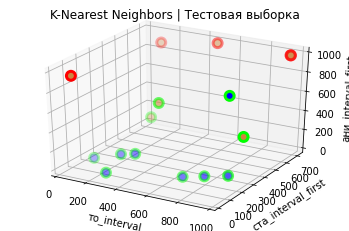

accuracy train: 0.9545454545454546 accuracy validation 0.7 accuracy_test 0.8125
              precision    recall  f1-score   support

           0       0.92      1.00      0.96        11
           1       1.00      0.91      0.95        11

    accuracy                           0.95        22
   macro avg       0.96      0.95      0.95        22
weighted avg       0.96      0.95      0.95        22

              precision    recall  f1-score   support

           0       0.62      1.00      0.77         5
           1       1.00      0.40      0.57         5

    accuracy                           0.70        10
   macro avg       0.81      0.70      0.67        10
weighted avg       0.81      0.70      0.67        10

              precision    recall  f1-score   support

           0       0.73      1.00      0.84         8
           1       1.00      0.62      0.77         8

    accuracy                           0.81        16
   macro avg       0.86      0.81      0.81     

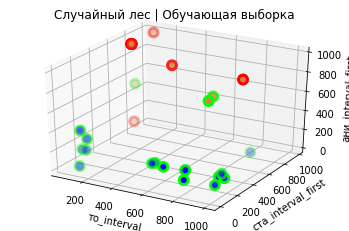

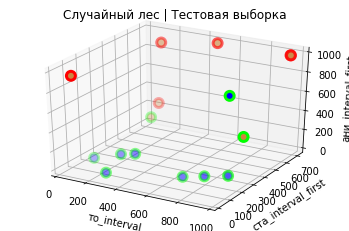

accuracy train: 1.0 accuracy validation 0.7 accuracy_test 0.875
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        11
           1       1.00      1.00      1.00        11

    accuracy                           1.00        22
   macro avg       1.00      1.00      1.00        22
weighted avg       1.00      1.00      1.00        22

              precision    recall  f1-score   support

           0       0.62      1.00      0.77         5
           1       1.00      0.40      0.57         5

    accuracy                           0.70        10
   macro avg       0.81      0.70      0.67        10
weighted avg       0.81      0.70      0.67        10

              precision    recall  f1-score   support

           0       0.80      1.00      0.89         8
           1       1.00      0.75      0.86         8

    accuracy                           0.88        16
   macro avg       0.90      0.88      0.87        16
weighted a

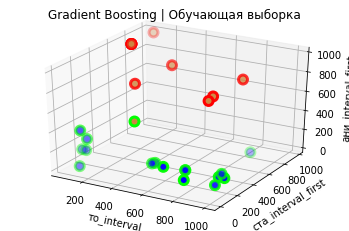

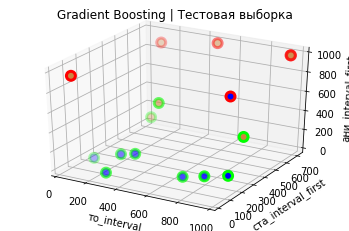

accuracy train: 1.0 accuracy validation 0.9 accuracy_test 0.75
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        11
           1       1.00      1.00      1.00        11

    accuracy                           1.00        22
   macro avg       1.00      1.00      1.00        22
weighted avg       1.00      1.00      1.00        22

              precision    recall  f1-score   support

           0       0.83      1.00      0.91         5
           1       1.00      0.80      0.89         5

    accuracy                           0.90        10
   macro avg       0.92      0.90      0.90        10
weighted avg       0.92      0.90      0.90        10

              precision    recall  f1-score   support

           0       0.70      0.88      0.78         8
           1       0.83      0.62      0.71         8

    accuracy                           0.75        16
   macro avg       0.77      0.75      0.75        16
weighted av

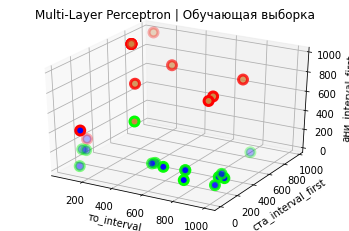

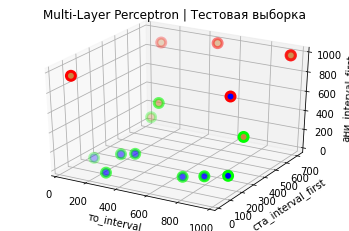

accuracy train: 1.0 accuracy validation 0.7 accuracy_test 0.75
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        11
           1       1.00      1.00      1.00        11

    accuracy                           1.00        22
   macro avg       1.00      1.00      1.00        22
weighted avg       1.00      1.00      1.00        22

              precision    recall  f1-score   support

           0       0.75      0.60      0.67         5
           1       0.67      0.80      0.73         5

    accuracy                           0.70        10
   macro avg       0.71      0.70      0.70        10
weighted avg       0.71      0.70      0.70        10

              precision    recall  f1-score   support

           0       0.70      0.88      0.78         8
           1       0.83      0.62      0.71         8

    accuracy                           0.75        16
   macro avg       0.77      0.75      0.75        16
weighted av

In [13]:
models = {
    'Logistic Regression': LogisticRegression(solver='lbfgs', random_state=0),
    'K-Nearest Neighbors': KNeighborsClassifier(n_neighbors=3),
    'Случайный лес': RandomForestClassifier(n_estimators=500, random_state=0),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=500, max_depth=2, random_state=0),
    'Multi-Layer Perceptron': MLPClassifier(hidden_layer_sizes=(512, 256, 128, 64, 32), alpha=0.001, max_iter=10000),
}

for k,v in models.items():
    print(k)
    report(v, x_train, y_train, x_test, y_test, X_test, Y_test)

### Модели детекции аномалий

Robust Covariance
*** TRAIN ***
pred: [ 1  1  1  1 -1  1  1  1 -1  1 -1  1  1  1  1  1]
train: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
REPORT:               precision    recall  f1-score   support

          -1       0.00      0.00      0.00         0
           1       1.00      0.81      0.90        16

    accuracy                           0.81        16
   macro avg       0.50      0.41      0.45        16
weighted avg       1.00      0.81      0.90        16



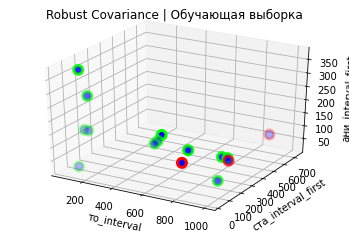

*** TEST ***
pred: [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1  1 -1  1 -1 -1 -1 -1 -1 -1 -1  1
  1 -1  1  1 -1  1  1  1]
test: [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
  1  1  1  1  1  1  1  1]
REPORT:               precision    recall  f1-score   support

          -1       0.91      0.83      0.87        24
           1       0.60      0.75      0.67         8

    accuracy                           0.81        32
   macro avg       0.75      0.79      0.77        32
weighted avg       0.83      0.81      0.82        32



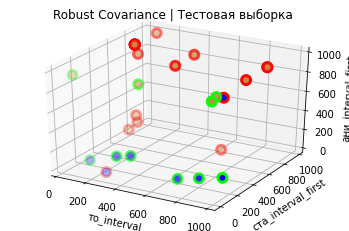


One-Class SVM
*** TRAIN ***
pred: [ 1 -1  1 -1 -1  1  1  1  1  1  1  1  1  1  1  1]
train: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
REPORT:               precision    recall  f1-score   support

          -1       0.00      0.00      0.00         0
           1       1.00      0.81      0.90        16

    accuracy                           0.81        16
   macro avg       0.50      0.41      0.45        16
weighted avg       1.00      0.81      0.90        16



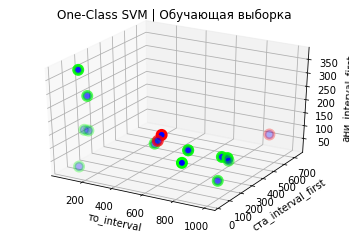

*** TEST ***
pred: [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1]
test: [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
  1  1  1  1  1  1  1  1]
REPORT:               precision    recall  f1-score   support

          -1       0.75      1.00      0.86        24
           1       0.00      0.00      0.00         8

    accuracy                           0.75        32
   macro avg       0.38      0.50      0.43        32
weighted avg       0.56      0.75      0.64        32



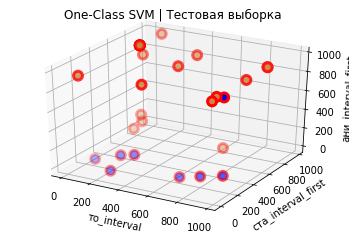


Изолирующий лес
*** TRAIN ***
pred: [ 1  1  1  1 -1  1  1  1  1  1  1  1  1 -1 -1  1]
train: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
REPORT:               precision    recall  f1-score   support

          -1       0.00      0.00      0.00         0
           1       1.00      0.81      0.90        16

    accuracy                           0.81        16
   macro avg       0.50      0.41      0.45        16
weighted avg       1.00      0.81      0.90        16



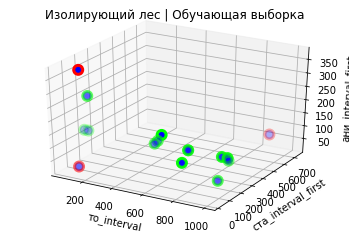

*** TEST ***
pred: [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
  1  1  1  1  1  1  1  1]
test: [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
  1  1  1  1  1  1  1  1]
REPORT:               precision    recall  f1-score   support

          -1       1.00      1.00      1.00        24
           1       1.00      1.00      1.00         8

    accuracy                           1.00        32
   macro avg       1.00      1.00      1.00        32
weighted avg       1.00      1.00      1.00        32



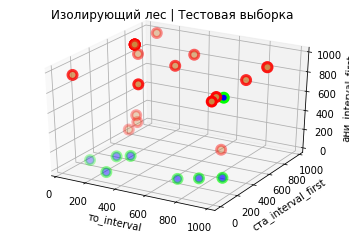


Local Outlier Factor
*** TRAIN ***
pred: [ 1  1  1  1 -1  1  1  1  1  1  1  1  1 -1 -1  1]
train: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
REPORT:               precision    recall  f1-score   support

          -1       0.00      0.00      0.00         0
           1       1.00      0.81      0.90        16

    accuracy                           0.81        16
   macro avg       0.50      0.41      0.45        16
weighted avg       1.00      0.81      0.90        16



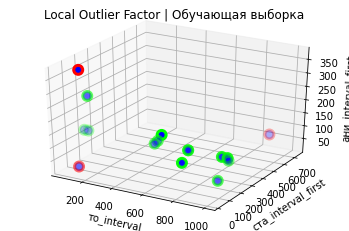

*** TEST ***
pred: [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1 -1 -1 -1
  1  1  1  1 -1  1  1  1]
test: [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
  1  1  1  1  1  1  1  1]
REPORT:               precision    recall  f1-score   support

          -1       0.96      0.96      0.96        24
           1       0.88      0.88      0.88         8

    accuracy                           0.94        32
   macro avg       0.92      0.92      0.92        32
weighted avg       0.94      0.94      0.94        32



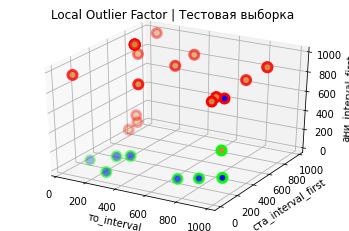

In [14]:
from sklearn import svm
from sklearn.covariance import EllipticEnvelope
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor

n_samples = len(x_train_anomaly)
outliers_fraction = 0.15
n_outliers = int(outliers_fraction * n_samples)
n_inliers = n_samples - n_outliers
LOF_novelty = True
# define outlier/anomaly detection methods to be compared
anomaly_algorithms = {
    "Robust Covariance": EllipticEnvelope(contamination=outliers_fraction),
    "One-Class SVM": svm.OneClassSVM(nu=outliers_fraction, kernel="rbf", gamma=0.1),
    "Изолирующий лес": IsolationForest(contamination=outliers_fraction, random_state=42),
    "Local Outlier Factor": LocalOutlierFactor(n_neighbors=35, contamination=outliers_fraction, novelty=LOF_novelty)
}

y_train_anomaly = np.full(len(y_train_anomaly.index), 1)
y_test_anomaly = np.where(y_test_anomaly == 1, -1, 1)

for name, algorithm in anomaly_algorithms.items():
        algorithm.fit(x_train_anomaly)

        # fit the data and tag outliers
        if name == "Local Outlier Factor":
            if not LOF_novelty:
                y_pred = algorithm.fit_predict(x_train_anomaly)
            else:
                y_pred_test = algorithm.predict(x_test_anomaly)
        else:
            y_pred = algorithm.predict(x_train_anomaly)
            y_pred_test = algorithm.predict(x_test_anomaly)
        
        if name == "Изолирующий лес":
            dump(algorithm, 'isolation_forest.joblib')
        
        print(name)
        print("*** TRAIN ***")
        print("pred:", y_pred)
        print("train:", y_train_anomaly)
        print("REPORT:", classification_report(y_train_anomaly, y_pred))
        plot3d(name + " | Обучающая выборка", x_train_anomaly, y_train_anomaly, y_pred, selected_columns)

        print("*** TEST ***")
        print("pred:", y_pred_test)
        print("test:", y_test_anomaly)
        print("REPORT:", classification_report(y_test_anomaly, y_pred_test))
        plot3d(name + " | Тестовая выборка ", x_test_anomaly, y_test_anomaly, y_pred_test, selected_columns)
        print()